In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math 

import warnings
warnings.filterwarnings("ignore")

# fix_yahoo_finance is used to fetch data 
import fix_yahoo_finance as yf
yf.pdr_override()

In [2]:
# input
symbol = 'AMD'
start = '2007-01-01'
end = '2019-01-01'

# Read data 
dataset = yf.download(symbol,start,end)

# View Columns
dataset.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-03,20.080000,20.400000,19.350000,19.520000,19.520000,28350300
2007-01-04,19.660000,19.860001,19.320000,19.790001,19.790001,23652500
2007-01-05,19.540001,19.910000,19.540001,19.709999,19.709999,15902400
2007-01-08,19.709999,19.860001,19.370001,19.469999,19.469999,15814800
2007-01-09,19.450001,19.709999,19.370001,19.650000,19.650000,14494200


In [3]:
dataset['Open_Close'] = (dataset['Open'] - dataset['Adj Close'])/dataset['Open']
dataset['High_Low'] = (dataset['High'] - dataset['Low'])/dataset['Low']
dataset['Increase_Decrease'] = np.where(dataset['Volume'].shift(-1) > dataset['Volume'],1,0)
dataset['Buy_Sell_on_Open'] = np.where(dataset['Open'].shift(-1) > dataset['Open'],1,0)
dataset['Buy_Sell'] = np.where(dataset['Adj Close'].shift(-1) > dataset['Adj Close'],1,0)
dataset['Returns'] = dataset['Adj Close'].pct_change()
dataset = dataset.dropna()
dataset.head()

,Open,High,Low,Close,Adj Close,Volume,Open_Close,High_Low,Increase_Decrease,Buy_Sell_on_Open,Buy_Sell,Returns
Date,,,,,,,,,,,,
2007-01-04,19.660000,19.860001,19.320000,19.790001,19.790001,23652500,-0.006612,0.027950,0,0,0,0.013832
2007-01-05,19.540001,19.910000,19.540001,19.709999,19.709999,15902400,-0.008700,0.018935,0,1,0,-0.004043
2007-01-08,19.709999,19.860001,19.370001,19.469999,19.469999,15814800,0.012177,0.025297,0,0,1,-0.012177
2007-01-09,19.450001,19.709999,19.370001,19.650000,19.650000,14494200,-0.010283,0.017553,1,1,1,0.009245
2007-01-10,19.639999,20.020000,19.500000,20.010000,20.010000,19783200,-0.018839,0.026667,1,1,1,0.018321


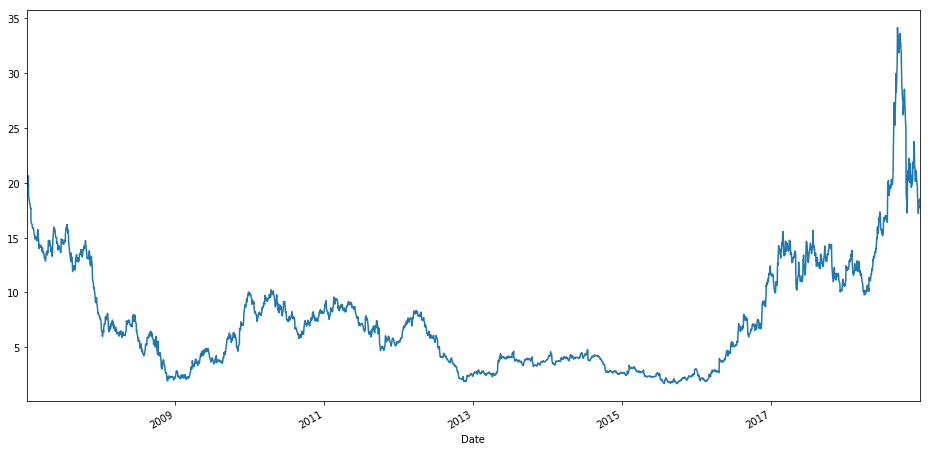

In [4]:
dataset['High'].plot(figsize=(16,8))

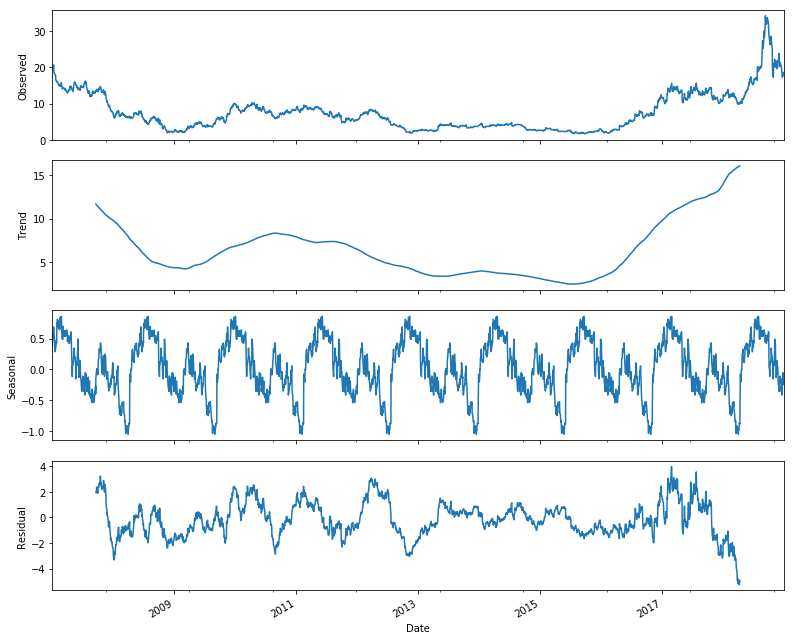

In [5]:
from pylab import rcParams
import statsmodels.api as sm

rcParams['figure.figsize'] = 11, 9
decomposed_volume = sm.tsa.seasonal_decompose(dataset["High"],freq=360) # The frequncy is annual
figure = decomposed_volume.plot()
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test on volume of stock 
adf = adfuller(dataset["Volume"])
print("p-value of stock: {}".format(float(adf[1])))

p-value of stock: 0.13082977813013869


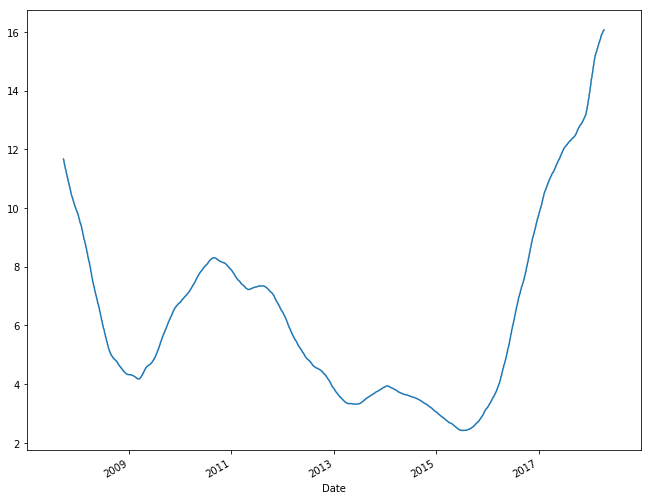

In [7]:
# The original non-stationary plot
decomposed_volume.trend.plot()

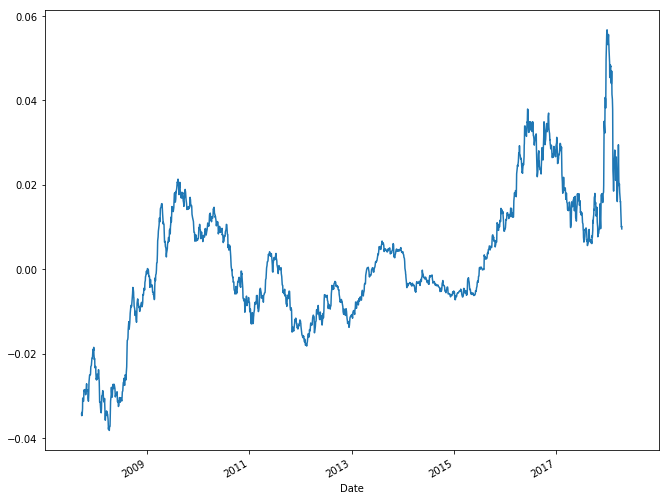

In [8]:
# The new stationary plot
decomposed_volume.trend.diff().plot()

## ARMA models

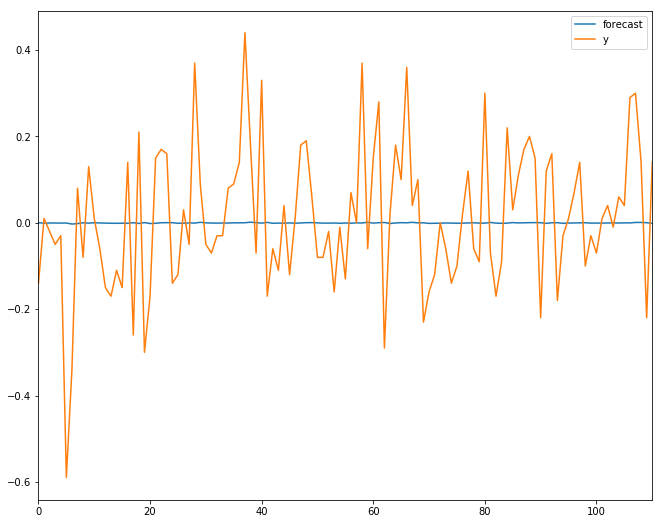

In [9]:
from statsmodels.tsa.arima_model import ARMA

# Predicting stock closing prices
humid = ARMA(dataset["Adj Close"].diff().iloc[1:].values, order=(1,0))
res = humid.fit()
res.plot_predict(start=900, end=1010)
plt.show()

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3018
Model:                     ARMA(3, 3)   Log Likelihood              -54687.701
Method:                       css-mle   S.D. of innovations       17918227.155
Date:                Sat, 03 Aug 2019   AIC                         109391.403
Time:                        14:06:31   BIC                         109439.501
Sample:                             0   HQIC                        109408.698
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.024e+04   2.78e+04      0.728      0.466   -3.42e+04    7.47e+04
ar.L1.y       -0.1433      0.241     -0.594      0.553      -0.616       0.330
ar.L2.y       -0.1441      0.159     -0.909      0.3

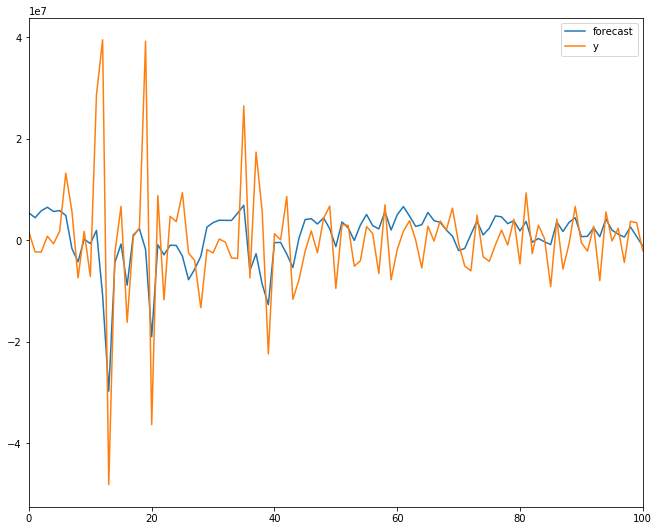

In [10]:
# Forecasting and predicting stocks volume
model = ARMA(dataset["Volume"].diff().iloc[1:].values, order=(3,3))
result = model.fit()
print(result.summary())
print("μ={}, ϕ={}, θ={}".format(result.params[0],result.params[1],result.params[2]))
result.plot_predict(start=1000, end=1100)
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(dataset["Volume"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 14284979.34203658.


## ARIMA models

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3017
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -55593.924
Method:                       css-mle   S.D. of innovations       24344581.840
Date:                Sat, 03 Aug 2019   AIC                         111195.848
Time:                        14:06:32   BIC                         111219.896
Sample:                             1   HQIC                        111204.496
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5545.9397   1.99e+05     -0.028      0.978   -3.96e+05    3.84e+05
ar.L1.D.y     -0.7837      0.016    -48.049      0.000      -0.816      -0.752
ar.L2.D.y     -0.4440      0.016    -27.233      0.0

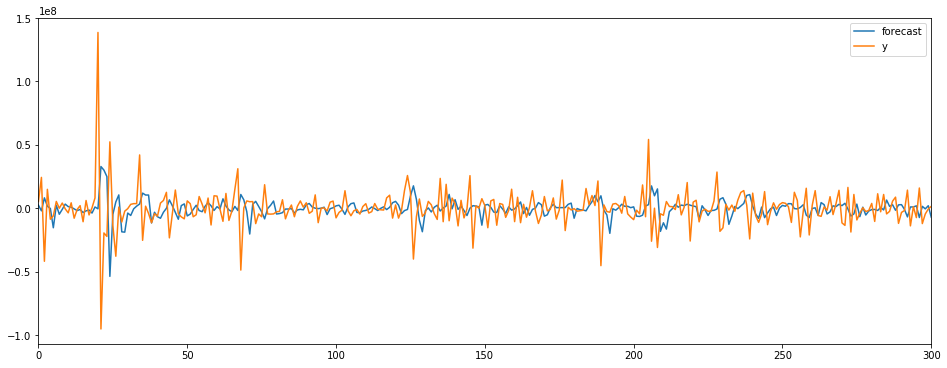

In [12]:
from statsmodels.tsa.arima_model import ARIMA

# Predicting the stocks volume
rcParams['figure.figsize'] = 16, 6
model = ARIMA(dataset["Volume"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
plt.show()

In [13]:
rmse = math.sqrt(mean_squared_error(dataset["Volume"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 30906449.48600048.
